In [1]:
import os
import random
from abc import abstractmethod
from os.path import join as oj
from tqdm import tqdm
from typing import Dict

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from joblib import Memory
import seaborn as sns
from sklearn.neighbors import KernelDensity   
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import sys
sys.path.append("../../../../")
from rulevetting.projects.tbi_pecarn.dataset import Dataset
from rulevetting.projects.tbi_pecarn import helper
from rulevetting.projects.tbi_pecarn import graph

# Set plotting font sizes and properties
TINY_SIZE = 12
SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 20
MARKER_SIZE = 6
LINE_SIZE = 4

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=TINY_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc("lines", markersize=MARKER_SIZE)  # marker size
plt.rc("lines", linewidth=LINE_SIZE)  # line width

mpl.rcParams["figure.dpi"] = 180

# Height and width per row and column of subplots
FIG_HEIGHT = 20
FIG_WIDTH = 18

fig_fcn = lambda kwargs: plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT), **kwargs)
color_list = sns.color_palette("colorblind")

%matplotlib inline

/Users/aprasad/Library/Python/3.9/lib/python/site-packages/redis/connection.py:72: UserWarning: redis-py works best with hiredis. Please consider installing
  warnings.warn(msg)


In [2]:
# Working directory
os.getcwd() #'/Users/marko/rule-vetting/rulevetting/projects/tbi_pecarn/notebooks'

'/Users/aprasad/Desktop/rule-vetting-master/rulevetting/projects/tbi_pecarn/notebooks'

In [3]:
# Load train, validation, and test data
df_train, df_tune, df_test = Dataset().get_data()
df_train.head()

kwargs {'clean_data': {}, 'preprocess_data': {'infer_outcome': True, 'drop_low_gcs': True, 'impute_unknowns': 'mode', 'impute_not_applicables': True}, 'extract_features': {}}


,InjuryMech_Assault,InjuryMech_Bicyclist struck by automobile,InjuryMech_Bike collision/fall,InjuryMech_Fall down stairs,InjuryMech_Fall from an elevation,InjuryMech_Fall to ground standing/walking/running,InjuryMech_Motor vehicle collision,InjuryMech_Object struck head - accidental,InjuryMech_Other mechanism,InjuryMech_Other wheeled crash,...,SFxPalp_Unclear,SFxPalp_Yes,FontBulg,Hema,Clav,NeuroD,OSI,Drugs,AgeTwoPlus,outcome
14091,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,2,0
20231,0,0,0,0,1,0,0,0,0,0,...,1,0,0,1,1,0,0,0,1,0
15798,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,2,0
223,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
6635,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,2,0


In [4]:
# Look at number of samples in each of training, validation, and test data
print(len(df_train))
print(len(df_tune))
print(len(df_test))

25458
8486
8486


In [5]:
# Load cleaned data
data_path = "../../../../data/"
df = Dataset().clean_data(data_path = data_path)

Reading the raw CSVs... ['TBI PUD 10-08-2013.csv', 'TBI PUD Imaging.csv', 'TBI PUD Neuro.csv']


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.35it/s]


In [6]:
print("Number of features: ", len(df.columns.tolist()))
print("Number of samples: ", len(df))

Number of features:  125
Number of samples:  43399


From the 'TBI PUD 10-08-2013.csv', there seem to be 20 patients without the outcome variable PosIntFinal. However in the frequencies of categorical variables, the union of missing Intub24Head, Neurosurgery, HospHeadPosCT, and DeathTBI is 1 which means at most 1 of the 20 cannot be inferred from these. If all of the known values (we exclude any 'Unknown' values) of the following columns: Intub24Head, Neurosurgery, HospHeadPosCT, and DeathTBI agree then then known value is used to infer the outcome. Otherwise, the outcome is left as 'Unknown'. Using this method, we are able to infer values for all of the 'Unknown' PosIntFinal values. 

In [7]:
def infer_missing_outcome(row):
    outcome = 'Unknown'
    # look at known outcome columns to infer outcome
    not_missing = [data for data in row if data != 'Unknown']
    
    # if all values that are known give the same answer, use that as the outcome
    if len(not_missing) > 0 and not_missing.count(not_missing[0]) == len(not_missing):
        outcome = not_missing[0]
    return outcome

outcome_vars = ['HospHeadPosCT', 'Intub24Head', 'Neurosurgery', 'DeathTBI']
df.loc[df['PosIntFinal'] == 'Unknown', 'PosIntFinal'] = df[df['PosIntFinal'] == 'Unknown'][outcome_vars].apply(infer_missing_outcome, axis=1)


Now we can pivot to see if similar analysis can be applied to our features. I first noticed HospHead has 3 missing values while HospHeadPosCT which is the intersection of HospHead and TBI on CT which has zero missing values. These all yield no however alongside PosCT which can imply HospHead was occured but there was no TBI on CT - hence we leave it as is.

In [8]:
df.loc[df['HospHead'] == 'Unknown', ['HospHead', 'PosCT', 'HospHeadPosCT']] 

,HospHead,PosCT,HospHeadPosCT
75,Unknown,No,No
9541,Unknown,No,No
42815,Unknown,No,No


Look at the rate of each of the four outcome types.

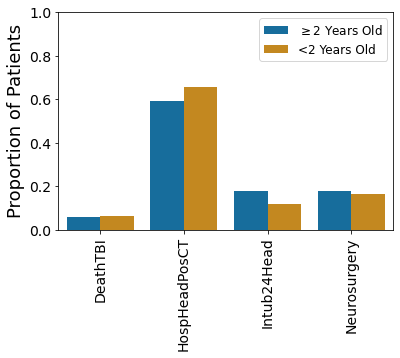

In [9]:
df_subset = df.loc[df['PosIntFinal'] == "Yes"][["AgeTwoPlus", 'DeathTBI', 'HospHeadPosCT', 'Intub24Head', 'Neurosurgery']]
df_subset = df_subset.replace("No", 0).replace("Yes", 1)
df_subset = df_subset.replace("Unknown", np.nan)
df_subset.loc[df_subset["AgeTwoPlus"] == 1, "AgeTwoPlus"] = '<2 Years Old'
df_subset.loc[df_subset["AgeTwoPlus"] == 2, "AgeTwoPlus"] = r'$\geq$' +  '2 Years Old'

df_subset = df_subset.groupby("AgeTwoPlus").sum()
df_subset = df_subset.div(df_subset.sum(axis=1), axis=0)
df_subset = df_subset.reset_index() 
df_subset = df_subset.melt(id_vars=["AgeTwoPlus"])
df_subset = df_subset.rename(columns={"AgeTwoPlus" : "Age"})

plt.figure()
sns.barplot(data=df_subset, x="variable", y="value", hue="Age", palette="colorblind")
plt.legend(title="")
plt.xlabel("")
plt.ylabel("Proportion of Patients")
plt.xticks(rotation=90)
plt.ylim(0, 1)
plt.savefig("./figs/outcome_type.png", bbox_inches="tight")


We look at the rate of ciTBI based on GCS class (3-13 v. 14-15). There is a stark difference with 40% of patients with GCS scores of 3-13 being positive for ciTBI versus 0.8% of those with GCS scores of 14-15. If we look at the rates for each individual GCS score we see they are high for low total GCS scores as we would expect and get lower as the GCS score gets higher. However, even for patients with a GCS score of 13, 20% of those patients are positive for a ciTBI. Thus, we can safely suggest getting a CT scan should be part of our rule for those patients with GCS score 3-13.

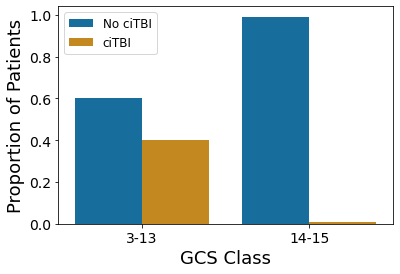

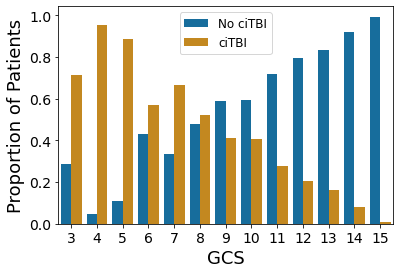

In [10]:
df2 = df.copy()
gcs_count_df = df2.groupby(["GCSGroup", "PosIntFinal"]).count().iloc[:, 0]
gcs_count_df = gcs_count_df / gcs_count_df.groupby(level=0).sum()
gcs_count_df = gcs_count_df.to_frame().reset_index()

gcs_count_df.loc[gcs_count_df["GCSGroup"] == 1, "GCSGroup"] = "3-13"
gcs_count_df.loc[gcs_count_df["GCSGroup"] == 2, "GCSGroup"] = "14-15"
gcs_count_df.loc[gcs_count_df["PosIntFinal"] == "No", "PosIntFinal"] = "No ciTBI"
gcs_count_df.loc[gcs_count_df["PosIntFinal"] == "Yes", "PosIntFinal"] = "ciTBI"

plt.figure()
sns.barplot(data=gcs_count_df, y="id", hue="PosIntFinal", x="GCSGroup", palette="colorblind")
plt.xlabel("GCS Class")
plt.ylabel("Proportion of Patients")
plt.legend(title="");
plt.savefig("./figs/GCSClass_prop.png", bbox_inches="tight")


gcs_total_df = df2.groupby(["GCSTotal", "PosIntFinal"]).count().iloc[:, 0]
gcs_total_df = gcs_total_df / gcs_total_df.groupby(level=0).sum()
gcs_total_df = gcs_total_df.to_frame().reset_index()
gcs_total_df.loc[gcs_total_df["PosIntFinal"] == "No", "PosIntFinal"] = "No ciTBI"
gcs_total_df.loc[gcs_total_df["PosIntFinal"] == "Yes", "PosIntFinal"] = "ciTBI"

plt.figure()
sns.barplot(data=gcs_total_df, y="id", hue="PosIntFinal", x="GCSTotal", palette="colorblind")
plt.xlabel("GCS")
plt.ylabel("Proportion of Patients")
plt.legend(title="");
plt.savefig("./figs/GCSTotal_prop.png", bbox_inches="tight")

/var/folders/dy/fnfy0mnd1m74gm4354thvzk8003ggn/T/ipykernel_52632/1644969474.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset["val"] = 1
/var/folders/dy/fnfy0mnd1m74gm4354thvzk8003ggn/T/ipykernel_52632/1644969474.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset["val"] = 1


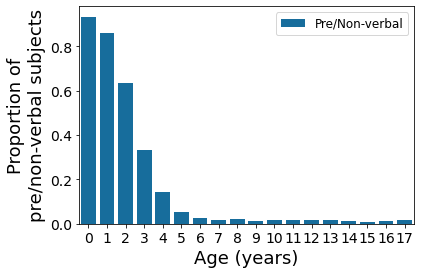

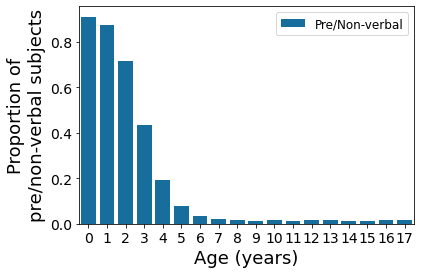

In [11]:
df2 = df.copy()
df_subset = df2[["HA_verb", "AgeinYears"]]
df_subset["val"] = 1
df_subset = df_subset.groupby(["HA_verb", "AgeinYears"]).count().iloc[:, 0]
df_subset = df_subset / df_subset.groupby(level=[1]).sum()
df_subset = df_subset.to_frame().reset_index()
df_subset = df_subset.loc[df_subset["HA_verb"] == "Pre/Non-verbal"]

plt.figure()
sns.barplot(data=df_subset, x="AgeinYears", y="val", hue="HA_verb", palette="colorblind")
plt.legend(title="")
plt.xlabel("Age (years)")
plt.ylabel("Proportion of\npre/non-verbal subjects");
plt.savefig("./figs/headache_preverbal.png", bbox_inches="tight")


df_subset = df2[["Amnesia_verb", "AgeinYears"]]
df_subset["val"] = 1
df_subset = df_subset.groupby(["Amnesia_verb", "AgeinYears"]).count().iloc[:, 0]
df_subset = df_subset / df_subset.groupby(level=[1]).sum()
df_subset = df_subset.to_frame().reset_index()
df_subset = df_subset.loc[df_subset["Amnesia_verb"] == "Pre/Non-verbal"]

plt.figure()
sns.barplot(data=df_subset, x="AgeinYears", y="val", hue="Amnesia_verb", palette="colorblind")
plt.legend(title="")
plt.xlabel("Age (years)")
plt.ylabel("Proportion of\npre/non-verbal subjects");
plt.savefig("./figs/amnesia_preverbal.png", bbox_inches="tight")




We remove patients with GCS scores between 3-13.

In [12]:
df_orig = df.copy()
df = df.loc[df['GCSTotal'] >= 14, :]
print(len(df_orig))
print(len(df))

43399
42430


The plot shows dizziness and ethnicity as the two most missing features by far.

/Users/aprasad/Library/Python/3.9/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


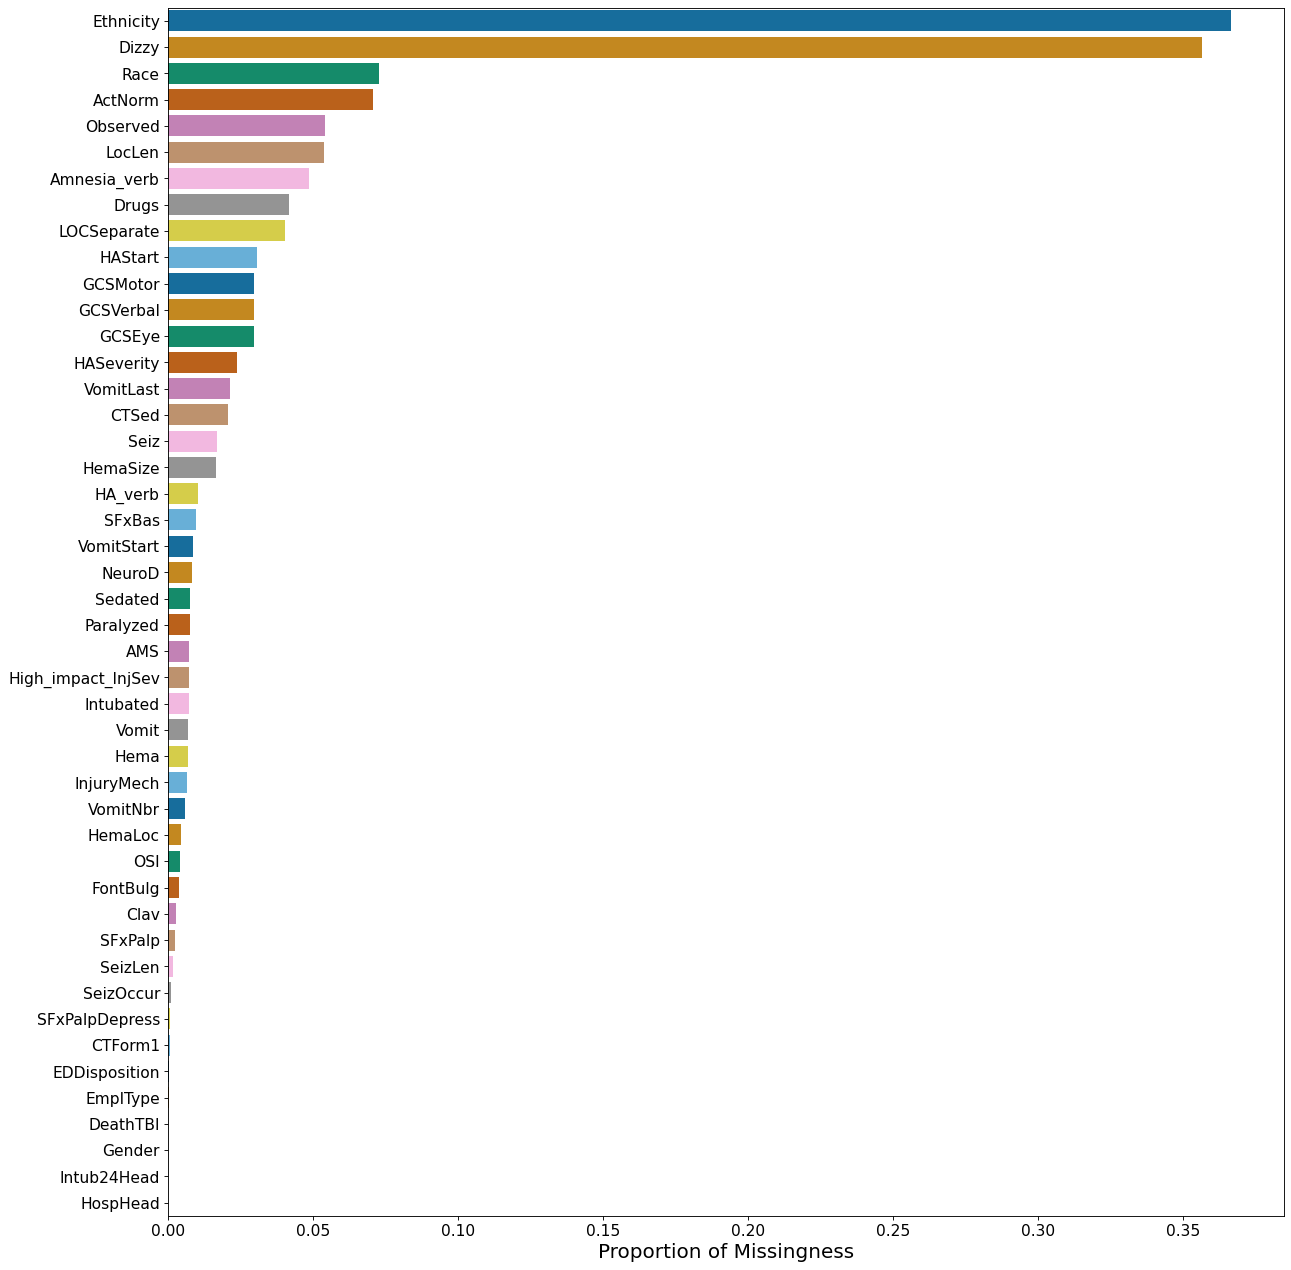

In [13]:
# Proportion of Missingness
pd.set_option('display.max_columns', 100)
na_col_counts = df.apply(lambda col: (col == 'Unknown').mean())
na_col_counts = na_col_counts[na_col_counts > 0]
na_col_counts = na_col_counts.sort_values(ascending=False)
graph.barplot(na_col_counts, 
        True, 
        None,
        "Proportion of Missingness"
)
plt.savefig("./figs/covariate_missingness.png", bbox_inches="tight")

To decide if there are entire columns we would want to remove, it may be helpful to examine the amount of missing values per sample. There do not appear to be many samples with a high percentage of missingness and thus we keep all of them.

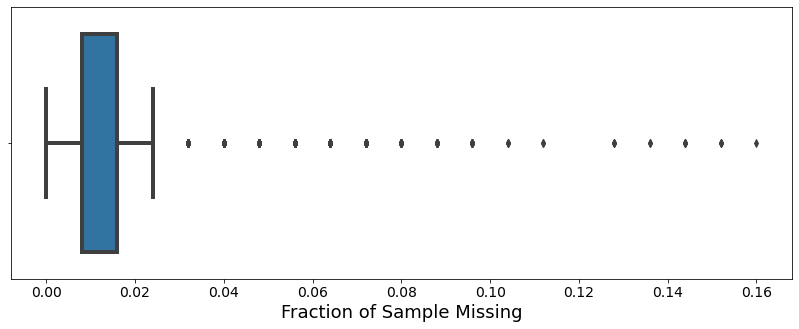

In [14]:
# plotting distribution of missing values per sample
X = df.apply(lambda col: (col == 'Unknown').sum() / len(col), axis=1).to_numpy().reshape(-1, 1)
fig, ax = plt.subplots(figsize=(14, 5))
sns.boxplot(x=X)
plt.xlabel('Fraction of Sample Missing')
plt.ylabel('')
plt.savefig("./figs/sample_missingness.png", bbox_inches="tight")

Here we can look at the 'Age' variable in particular to get a better sense of its distribution.
(Note: sns uses a Gaussian KDE.)

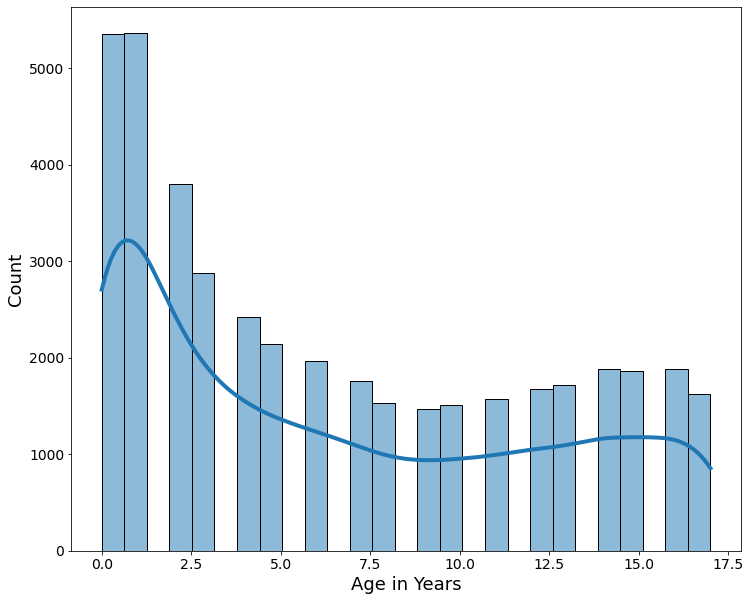

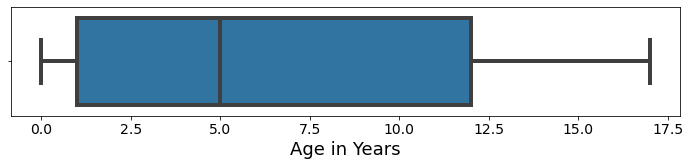

In [15]:
feature = 'AgeinYears'

fig, ax = plt.subplots(figsize=(12,10))
sns.histplot(data=df, x=feature, kde=True)
plt.xlabel("Age in Years")
plt.savefig("figs/" + "age_dist.png", dpi=350)

fig, ax = plt.subplots(figsize=(12,2))
ax = sns.boxplot(data=df, x=feature)
plt.xlabel("Age in Years")
plt.savefig("./figs/age_box.png", bbox_inches="tight")


Here I would like to examine the distribution of outcome for those <= 2 years old v > 2 years old. The first plot shows the proportion of patients in each group in the data (all bars sum to 2). The second plot shows the proportion of patients with and without cTBI per age group where bars for each age class sum to 1. We can see the rate of ciTBI is the same for each age group, even though there are more patients in the >=2 group.

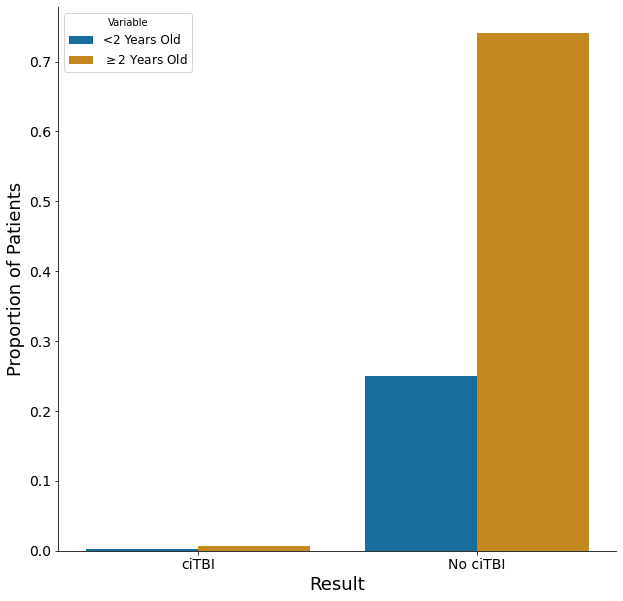

In [16]:
df2 = df.copy()
old_citbi = len(df2[(df2['AgeTwoPlus'] == 2) & (df2['PosIntFinal'] == 'Yes')]) 
old_no_citbi = len(df2[df2['AgeTwoPlus'] == 2]) - old_citbi
young_citbi = len(df2[(df2['AgeTwoPlus'] == 1) & (df2['PosIntFinal'] == 'Yes')]) 
young_no_citbi = len(df2[df2['AgeTwoPlus'] == 1]) - young_citbi
total_ct = len(df2[df2['AgeTwoPlus'] == 2]) + len(df2[df2['AgeTwoPlus'] == 1])
age = pd.DataFrame(data={'Result': ['ciTBI', 'No ciTBI'], 
                         '<2 Years Old': [young_citbi / total_ct, young_no_citbi / total_ct],
                         r'$\geq$' +  '2 Years Old': [old_citbi / total_ct, old_no_citbi / total_ct]})

fig, ax1 = plt.subplots(figsize=(10, 10))
tidy = age.melt(id_vars='Result').rename(columns=str.title)
sns.barplot(x='Result', y='Value', hue='Variable', data=tidy, ax=ax1, palette="colorblind")
plt.ylabel('Proportion of Patients')
sns.despine(fig)
plt.savefig("figs/" + "age_comparison.png", dpi=350)

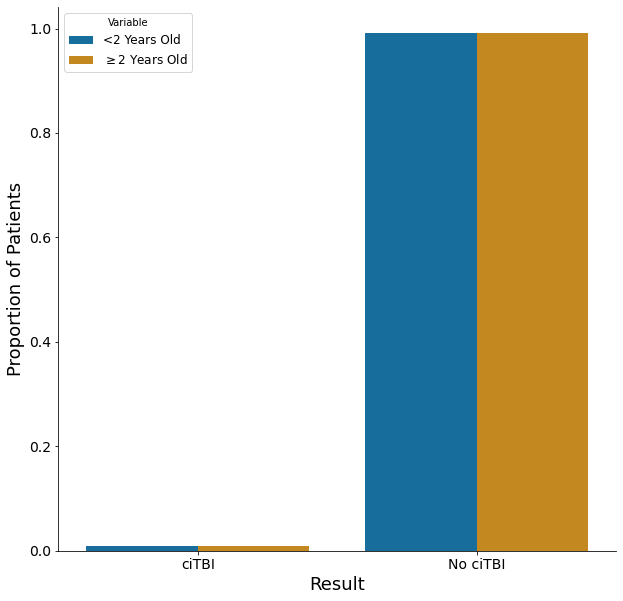

In [17]:
df2 = df.copy()
old_citbi = len(df2[(df2['AgeTwoPlus'] == 2) & (df2['PosIntFinal'] == 'Yes')]) 
old_no_citbi = len(df2[df2['AgeTwoPlus'] == 2]) - old_citbi
young_citbi = len(df2[(df2['AgeTwoPlus'] == 1) & (df2['PosIntFinal'] == 'Yes')]) 
young_no_citbi = len(df2[df2['AgeTwoPlus'] == 1]) - young_citbi
total_ct = [len(df2[df2['AgeTwoPlus'] == 2]), len(df2[df2['AgeTwoPlus'] == 1])]
age = pd.DataFrame(data={'Result': ['ciTBI', 'No ciTBI'], 
                         '<2 Years Old': [young_citbi / total_ct[1], young_no_citbi / total_ct[1]],
                         r'$\geq$' +  '2 Years Old': [old_citbi / total_ct[0], old_no_citbi / total_ct[0]]})

fig, ax1 = plt.subplots(figsize=(10, 10))
tidy = age.melt(id_vars='Result').rename(columns=str.title)
sns.barplot(x='Result', y='Value', hue='Variable', data=tidy, ax=ax1, palette="colorblind")
plt.ylabel('Proportion of Patients')
sns.despine(fig)
plt.savefig("figs/" + f"age_comparison_by_group.png", dpi=350)

Next, we look more closely at the distribution of binary variables that could contribute to predicting ciTBI for each age group.

<Figure size 432x288 with 0 Axes>

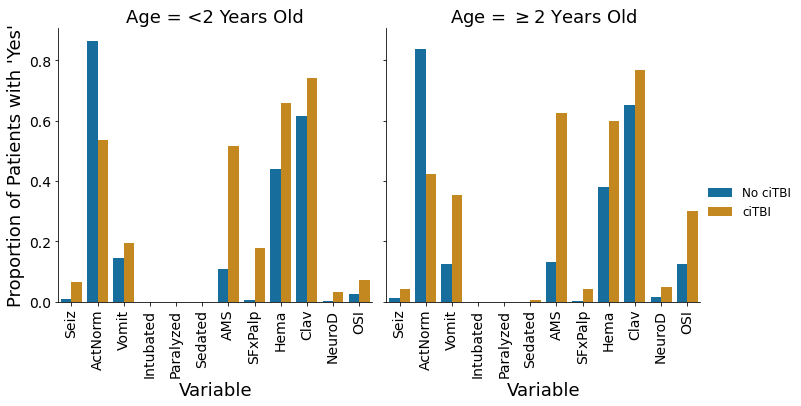

In [18]:
var_subset = ["Seiz", "ActNorm", "Vomit", 
 "Intubated", "Paralyzed", "Sedated", 
 "AMS", "SFxPalp", "Hema", "Clav", "NeuroD", "OSI"]

df_subset = df[var_subset + ["AgeTwoPlus", "PosIntFinal"]]
df_subset = df_subset.loc[df_subset["SFxPalp"] != 2]
df_subset = df_subset.replace("No", 0)
df_subset = df_subset.replace("Yes", 1)
df_subset = df_subset.replace("Unclear", np.nan)
df_subset = df_subset.replace("Unknown", np.nan)

df_subset = df_subset.groupby(["AgeTwoPlus", "PosIntFinal"]).mean().reset_index()
df_subset.loc[df_subset["PosIntFinal"] == 0, "PosIntFinal"] = "No ciTBI"
df_subset.loc[df_subset["PosIntFinal"] == 1, "PosIntFinal"] = "ciTBI"
df_subset.loc[df_subset["AgeTwoPlus"] == 1, "AgeTwoPlus"] = '<2 Years Old'
df_subset.loc[df_subset["AgeTwoPlus"] == 2, "AgeTwoPlus"] = r'$\geq$' +  '2 Years Old'

df_subset = df_subset.melt(id_vars=["AgeTwoPlus", "PosIntFinal"])
df_subset = df_subset.rename(columns={"AgeTwoPlus" : "Age"})
plt.figure()
g = sns.catplot(kind="bar", data=df_subset, x="variable", y="value", 
            hue="PosIntFinal", col="Age", palette="colorblind")
g.set_axis_labels("Variable", "Proportion of Patients with 'Yes'" )
g.set_xticklabels(rotation=90)
g._legend.set_title("")
plt.savefig("./figs/covariate_by_age.png", bbox_inches="tight")


<Figure size 432x288 with 0 Axes>

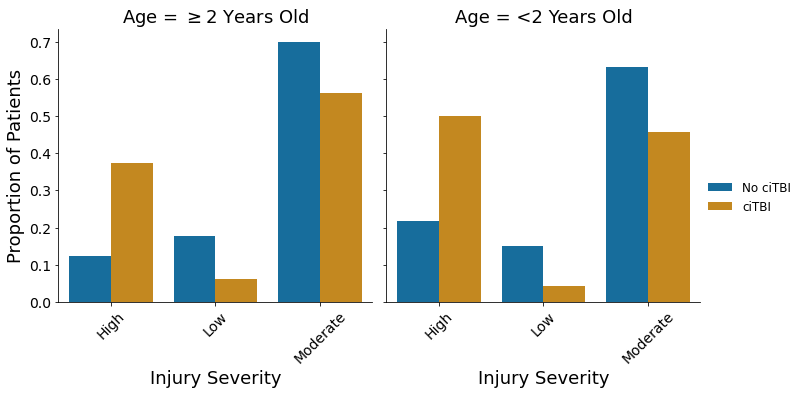

In [19]:
df_subset = df[["AgeTwoPlus", "PosIntFinal", "High_impact_InjSev"]]
df_subset = df_subset.loc[df_subset["High_impact_InjSev"] != "Unknown"]
df_subset.loc[df_subset["PosIntFinal"] == "No", "PosIntFinal"] = "No ciTBI"
df_subset.loc[df_subset["PosIntFinal"] == "Yes", "PosIntFinal"] = "ciTBI"
df_subset.loc[df_subset["AgeTwoPlus"] == 1, "AgeTwoPlus"] = '<2 Years Old'
df_subset.loc[df_subset["AgeTwoPlus"] == 2, "AgeTwoPlus"] = r'$\geq$' +  '2 Years Old'

df_subset["val"] = 1
df_subset = df_subset.groupby(["AgeTwoPlus", 
                               "PosIntFinal", 
                               "High_impact_InjSev"]).count()
df_subset = df_subset / df_subset.groupby(level=[0, 1]).sum()
df_subset = df_subset.iloc[:, 0].to_frame().reset_index()

df_subset = df_subset.rename(columns={"AgeTwoPlus" : "Age"})

plt.figure()
g = sns.catplot(kind="bar", data=df_subset, x="High_impact_InjSev", y="val", 
            hue="PosIntFinal", col="Age", palette="colorblind")
g.set_axis_labels("Injury Severity", "Proportion of Patients" )
g.set_xticklabels(rotation=45)
g._legend.set_title("")
plt.savefig("./figs/age_by_injuryseverity.png", bbox_inches="tight")

<Figure size 432x288 with 0 Axes>

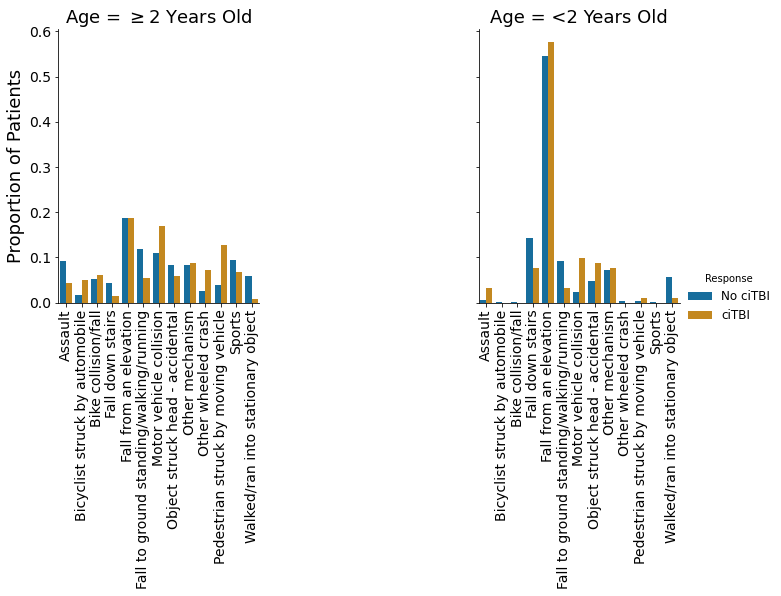

In [20]:
df_subset = df[["AgeTwoPlus", "PosIntFinal", "InjuryMech"]]
df_subset = df_subset.loc[df_subset["InjuryMech"] != "Unknown"]
df_subset.loc[df_subset["PosIntFinal"] == "No", "PosIntFinal"] = "No ciTBI"
df_subset.loc[df_subset["PosIntFinal"] == "Yes", "PosIntFinal"] = "ciTBI"
df_subset.loc[df_subset["AgeTwoPlus"] == 1, "AgeTwoPlus"] = '<2 Years Old'
df_subset.loc[df_subset["AgeTwoPlus"] == 2, "AgeTwoPlus"] = r'$\geq$' +  '2 Years Old'

df_subset["val"] = 1
df_subset = df_subset.groupby(["AgeTwoPlus", 
                               "PosIntFinal", 
                               "InjuryMech"]).count()
df_subset = df_subset / df_subset.groupby(level=[0, 1]).sum()
df_subset = df_subset.iloc[:, 0].to_frame().reset_index()

df_subset = df_subset.rename(columns={"AgeTwoPlus" : "Age", "PosIntFinal" : "Response"})

plt.figure()
g = sns.catplot(kind="bar", data=df_subset, x="InjuryMech", y="val", 
            #row="Response", 
                hue="Response", col="Age", palette="colorblind")
g.set_axis_labels("", "Proportion of Patients" )
g.set_xticklabels(rotation=90)
plt.savefig("./figs/age_by_injury_type.png", bbox_inches="tight")



Look at number of pre-verbal responses in headache and amnesia features.

In [21]:
df_subset = df[['AgeTwoPlus', "Amnesia_verb", "PosIntFinal"]]
df_subset["val"] = 1
df_subset = df_subset.groupby(['AgeTwoPlus', "Amnesia_verb", "PosIntFinal"]).count()
print(df_subset)
df_subset = df_subset / df_subset.groupby(level=[0, 1]).sum()
print(df_subset)

                                         val
AgeTwoPlus Amnesia_verb   PosIntFinal       
1          No             No             791
                          Yes              3
           Pre/Non-verbal No            9470
                          Yes             90
           Unknown        No             355
                          Yes              4
           Yes            No               7
                          Yes              1
2          No             No           20809
                          Yes             97
           Pre/Non-verbal No            4622
                          Yes             43
           Unknown        No            1676
                          Yes             37
           Yes            No            4324
                          Yes            101
                                            val
AgeTwoPlus Amnesia_verb   PosIntFinal          
1          No             No           0.996222
                          Yes          0.00377

/var/folders/dy/fnfy0mnd1m74gm4354thvzk8003ggn/T/ipykernel_52632/3571949226.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset["val"] = 1


In [22]:
df_subset = df[['AgeTwoPlus', "HA_verb", "PosIntFinal"]]
df_subset["val"] = 1
df_subset = df_subset.groupby(['AgeTwoPlus', "HA_verb", "PosIntFinal"]).count()
print(df_subset)
df_subset = df_subset / df_subset.groupby(level=[0, 1]).sum()
print(df_subset)

                                         val
AgeTwoPlus HA_verb        PosIntFinal       
1          No             No             995
                          Yes              3
           Pre/Non-verbal No            9531
                          Yes             93
           Unknown        No              72
                          Yes              2
           Yes            No              25
2          No             No           14765
                          Yes             59
           Pre/Non-verbal No            3795
                          Yes             36
           Unknown        No             352
                          Yes             20
           Yes            No           12519
                          Yes            163
                                            val
AgeTwoPlus HA_verb        PosIntFinal          
1          No             No           0.996994
                          Yes          0.003006
           Pre/Non-verbal No           0.99

/var/folders/dy/fnfy0mnd1m74gm4354thvzk8003ggn/T/ipykernel_52632/2251286740.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset["val"] = 1


Here we look at "parent" features and analyze which ones are no and the subsequent questions are not applicable - we can infer these. 

In [23]:
def frac_no_not_applicable(df, feat, subfeats):
    # df - dataframe
    # feat - string of feature with subfeatues - example vomit, seiz, ...
    # subfeats - those subfeatures - vomitnbr, etc.
    # return fraction of those subfeats that are not applicable and parent var is no
    for subfeat in subfeats:
        print(f'{feat} and {subfeat}')
        print(len(df[(df[feat] == 'No') & (df[subfeat] == 'Not applicable')]) / len(df[df[feat] == 'No']))
        
# loc vars
frac_no_not_applicable(df, 'LOCSeparate', ['LocLen'])

# seiz vars
frac_no_not_applicable(df, 'Seiz', ['SeizOccur', 'SeizLen'])

# ha vars
frac_no_not_applicable(df, 'HA_verb', ['HASeverity', 'HAStart'])

# vomit vars
frac_no_not_applicable(df, 'Vomit', ['VomitNbr', 'VomitStart', 'VomitLast'])

# ams vars
frac_no_not_applicable(df, 'AMS', ['AMSAgitated', 'AMSSleep', 'AMSSlow', 'AMSRepeat', 'AMSOth'])

# sfx vars
frac_no_not_applicable(df, 'SFxPalp', ['SFxPalpDepress'])

# sfxbas vars
frac_no_not_applicable(df, 'SFxBas', ['SFxBasHem', 'SFxBasHem', 'SFxBasOto', 'SFxBasPer', 'SFxBasRet', 'SFxBasRhi'])

# hema vars
frac_no_not_applicable(df, 'Hema', ['HemaLoc', 'HemaSize'])

# clav vars
frac_no_not_applicable(df, 'Clav', ['ClavFace', 'ClavNeck', 'ClavFro', 'ClavOcc', 'ClavPar', 'ClavTem'])

LOCSeparate and LocLen
1.0
Seiz and SeizOccur
1.0
Seiz and SeizLen
1.0
HA_verb and HASeverity
1.0
HA_verb and HAStart
1.0
Vomit and VomitNbr
1.0
Vomit and VomitStart
1.0
Vomit and VomitLast
1.0
AMS and AMSAgitated
1.0
AMS and AMSSleep
1.0
AMS and AMSSlow
1.0
AMS and AMSRepeat
1.0
AMS and AMSOth
1.0
SFxPalp and SFxPalpDepress
1.0
SFxBas and SFxBasHem
1.0
SFxBas and SFxBasHem
1.0
SFxBas and SFxBasOto
1.0
SFxBas and SFxBasPer
1.0
SFxBas and SFxBasRet
1.0
SFxBas and SFxBasRhi
1.0
Hema and HemaLoc
1.0
Hema and HemaSize
1.0
Clav and ClavFace
1.0
Clav and ClavNeck
1.0
Clav and ClavFro
1.0
Clav and ClavOcc
1.0
Clav and ClavPar
1.0
Clav and ClavTem
1.0


Rename 'PosIntFinal' to 'outcome'. Drop any variables that are recorded after a CT scan was already obtained or are directly related to getting a CT scan.

In [24]:
# remove post-ct vars and examine relationships with outcome variable
df1 = df.copy()
df1 = df1[df1['PosIntFinal'] != 'Unknown']
df1.rename(columns = {'PosIntFinal':'outcome'}, inplace=True)
df1 = df1.drop(columns=Dataset().get_post_ct_names())
df1 = df1.drop(columns=['id', 'EmplType', 'Certification', 'Ethnicity', 'Race', 'Gender', 'Dizzy',
                      'AgeInMonth', 'AgeinYears', 'GCSTotal', 'GCSGroup'])
print(df.shape)
print(df1.shape)

(42430, 125)
(42430, 64)


We next look at the Spearman correlation of each feature to the outcome. None seem to have a really strong correlation to the outcome.

/Users/aprasad/Library/Python/3.9/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, 'Outcome Correlation')

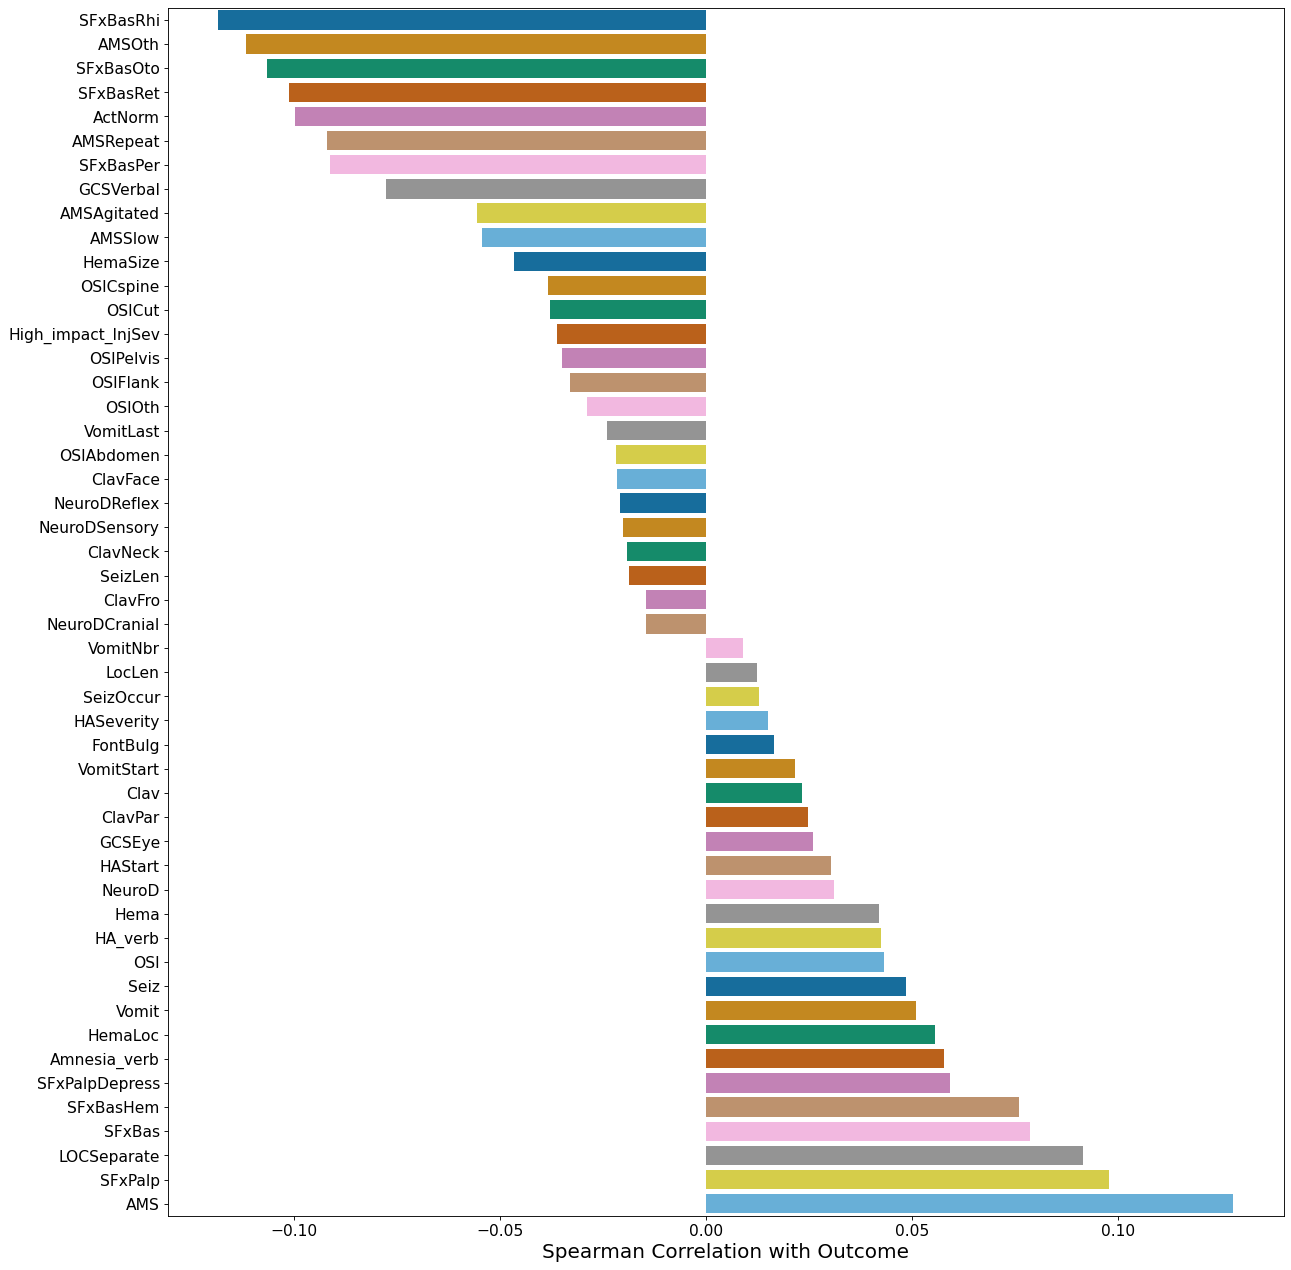

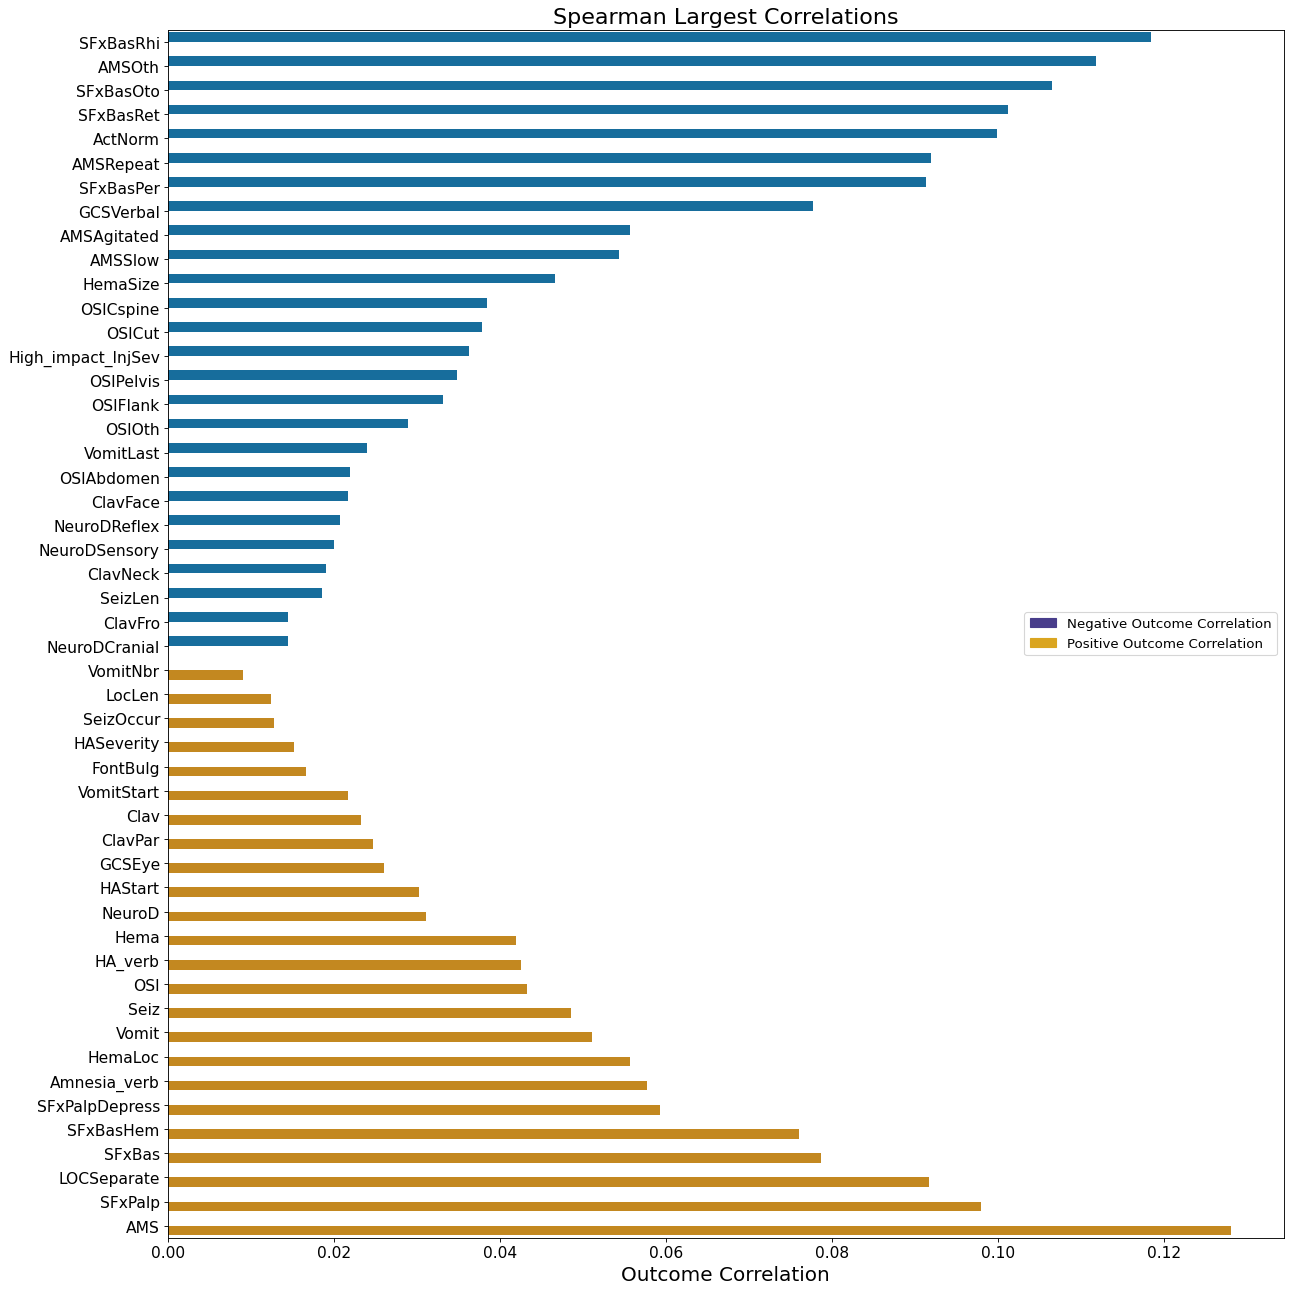

In [25]:
# calculate correlation of variable with outcome
corr = df1.drop(['outcome'], axis=1).apply(lambda x: x.corr(df1['outcome'], method='spearman'))

# sortest by largest value
largest_corr = corr.iloc[corr.abs().argsort()][-50:].sort_values(ascending=True)
graph.barplot(largest_corr, savefig=True, title=None, xlab='Spearman Correlation with Outcome')
plt.savefig("./figs/spearman_corr_to_outcome.png", bbox_inches="tight")

# sort by absolute value
abs_corr = corr.abs().sort_values(ascending=True)
fig_fcn = lambda kwargs: plt.figure(figsize=(18, 20), **kwargs)
fig_fcn({"num": None, "dpi": 80, "facecolor": "w", "edgecolor": "r"})
sns.barplot(x=abs_corr[largest_corr.index].values, y=abs_corr[largest_corr.index].index, hue=[1 if corr > 0 else 0 for corr in largest_corr.values], palette='colorblind')
handles = [mpl.patches.Patch(color='darkslateblue', label='Negative Outcome Correlation'), mpl.patches.Patch(color='goldenrod', label='Positive Outcome Correlation')]
plt.legend(handles=handles, loc='center right')
plt.title('Spearman Largest Correlations')
plt.xlabel('Outcome Correlation')

One hot encode the data.

In [26]:
# remapping binary variables
bool_cols = [col for col in df1 if np.isin(df1[col].unique(), ['No', 'Yes']).all()]
for bool_col in bool_cols:
    df1[bool_col] = df1[bool_col].map({'No': 0, 'Yes': 1})

# one hot encoding the df
one_hot_df = helper.one_hot_encode_df(df1)


/usr/local/lib/python3.9/site-packages/numpy/lib/arraysetops.py:608: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Here I would like to look at the GCS variables to resolve what to do for preprocessing. My initial thought process was that increasing the age would increase the likelihood of more accurate GCS scores - long story short, I was wrong. On a similar note, the clinician believed that unknowns were proxies for just normal kids, but GCSVerbal and GCSMotor with unknowns had a much larger correlation to ciTBI, the outcome, and the means of the GCSTotal scores were lower with unknown scores. My thought from plotting and analyzing the empirical distributions is to do the contrary and instead impute this as if the patient were not well. This is a judgement call - the alternatives are really: 1) impute patient as normal, 2) remove patient altogether, 3) do nothing, or maybe 4) impute according to mean/median which IMO aren't better if we trust the data itself (not sure). I am more tempted to actually just remove these categorical ones - GCSEye, GCSVerbal, and GCSMotor and instead rely on the GCSTotal as none are missing and the ones with missing subcategories - Eye/Verbal/Motor - happened to still have GCSTotal. 

In [27]:
"""# GCS score plots
fig, axs = plt.subplots(nrows=18, sharex=True,  figsize=(23,35))
for i in range(18):
    sns.countplot(x='GCSEye', data=df1[(df1['AgeinYears'] == i) & (df1['outcome'] == 0)], 
                  ax=axs[i], palette="colorblind")
    axs[i].set_ylabel(f'Age {i}')
    axs[i].set_xlabel('')
    axs[i].bar_label(axs[i].containers[0])
    if i == 17:
        axs[i].set_xlabel('GCSTotal')
        
plt.ylabel('Count')"""

'# GCS score plots\nfig, axs = plt.subplots(nrows=18, sharex=True,  figsize=(23,35))\nfor i in range(18):\n    sns.countplot(x=\'GCSEye\', data=df1[(df1[\'AgeinYears\'] == i) & (df1[\'outcome\'] == 0)], \n                  ax=axs[i], palette="colorblind")\n    axs[i].set_ylabel(f\'Age {i}\')\n    axs[i].set_xlabel(\'\')\n    axs[i].bar_label(axs[i].containers[0])\n    if i == 17:\n        axs[i].set_xlabel(\'GCSTotal\')\n        \nplt.ylabel(\'Count\')'

Now we plot the distributions of some of the features with the most correlated encodings:

In [28]:
"""plot_count = 10
correlated_feats = list(set([feat.split('_')[0] for feat in abs_corr.index.tolist()]))
fig, axs = plt.subplots(nrows=plot_count, sharex=True,  figsize=(20,18))
fig.tight_layout()
for i in range(plot_count):
    sns.countplot(y=correlated_feats[i], data=df, ax=axs[i], palette="colorblind")
    axs[i].set_xlabel('')
plt.xlabel('Count')"""

'plot_count = 10\ncorrelated_feats = list(set([feat.split(\'_\')[0] for feat in abs_corr.index.tolist()]))\nfig, axs = plt.subplots(nrows=plot_count, sharex=True,  figsize=(20,18))\nfig.tight_layout()\nfor i in range(plot_count):\n    sns.countplot(y=correlated_feats[i], data=df, ax=axs[i], palette="colorblind")\n    axs[i].set_xlabel(\'\')\nplt.xlabel(\'Count\')'

Shown is a correlation heatmap. Code below takes to long to run as there are too many features at the moment if using them all. Instead we can skip over this and perform PCA on the one-hot-encoded data instead.

In [29]:
"""# plotting correlation of most positively correlated features to outcome
corr = one_hot_df[['outcome'] + largest_corr.index.tolist()].corr(method='spearman')

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.savefig("figs/" + f"heatmap.png", dpi=350, bbox_inches='tight')"""

'# plotting correlation of most positively correlated features to outcome\ncorr = one_hot_df[[\'outcome\'] + largest_corr.index.tolist()].corr(method=\'spearman\')\n\n# Generate a mask for the upper triangle\nmask = np.triu(np.ones_like(corr, dtype=bool))\n\n# Set up the matplotlib figure\nfig, ax = plt.subplots(figsize=(11, 9))\n\n# Generate a custom diverging colormap\ncmap = sns.diverging_palette(230, 20, as_cmap=True)\n\n# Draw the heatmap with the mask and correct aspect ratio\nsns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,\n            square=True, linewidths=.5, cbar_kws={"shrink": .5})\nplt.savefig("figs/" + f"heatmap.png", dpi=350, bbox_inches=\'tight\')'

## Variable Transformations
In this section, I would like to test if the distributions of outcomes are the same for the categories say >15min, 1-5min, etc. for SeizLen, LocLen, etc. is justified by using a Fisher's exact test. The goal is to see if any categories should be collapsed.

The features in question are: High_impact_InjSev, LocLen, SeizOccur, SeizLen, HASeverity, HAStart, VomitNbr, VomitStart, VomitLast, HemaLoc, and HemaSize.

In [30]:
"""from scipy.stats import ks_2samp
from itertools import permutations
from scipy.stats import fisher_exact

# remapping binary variables
bool_cols = [col for col in df if np.isin(df[col].unique(), ['No', 'Yes']).all()]
for bool_col in bool_cols:
    df[bool_col] = df[bool_col].map({'No': 0, 'Yes': 1})
    
suspect_vars = ['High_impact_InjSev', 'LocLen', 'SeizOccur', 'SeizLen', 'HASeverity',
               'HAStart', 'VomitNbr', 'VomitStart', 'VomitLast', 'HemaLoc', 'HemaSize']

def fish_test(df, feature, p_tol):
    print(f'Test for feature {feature}:\n')
    categories = df[feature].unique()
    for i in range(len(categories)):
        for j in range(i + 1, len(categories)):
            x = df[df[feature] == categories[i]]['outcome']
            y = df[df[feature] == categories[j]]['outcome']
            A = np.zeros((2, 2))
            A[0, 0] = x.sum()
            A[0, 1] = len(x) - A[0, 0]
            A[1, 0] = y.sum()
            A[1, 1] = len(y) - A[1, 0]
            p_val = fisher_exact(A)[1]
            if p_val <= p_tol / ((len(categories) - 1) * len(categories)): # Bonferroni
                print(f'{categories[i]} and {categories[j]} have different distributions.')
            else:
                print(f'{categories[i]} and {categories[j]} have the same distribution.')

    print('\n')
            
for var in suspect_vars:
    fish_test(df1, var, 0.05)"""

"from scipy.stats import ks_2samp\nfrom itertools import permutations\nfrom scipy.stats import fisher_exact\n\n# remapping binary variables\nbool_cols = [col for col in df if np.isin(df[col].unique(), ['No', 'Yes']).all()]\nfor bool_col in bool_cols:\n    df[bool_col] = df[bool_col].map({'No': 0, 'Yes': 1})\n    \nsuspect_vars = ['High_impact_InjSev', 'LocLen', 'SeizOccur', 'SeizLen', 'HASeverity',\n               'HAStart', 'VomitNbr', 'VomitStart', 'VomitLast', 'HemaLoc', 'HemaSize']\n\ndef fish_test(df, feature, p_tol):\n    print(f'Test for feature {feature}:\n')\n    categories = df[feature].unique()\n    for i in range(len(categories)):\n        for j in range(i + 1, len(categories)):\n            x = df[df[feature] == categories[i]]['outcome']\n            y = df[df[feature] == categories[j]]['outcome']\n            A = np.zeros((2, 2))\n            A[0, 0] = x.sum()\n            A[0, 1] = len(x) - A[0, 0]\n            A[1, 0] = y.sum()\n            A[1, 1] = len(y) - A[1, 0]\n 

# PCA Analysis

In [31]:
# Some preprocessing - should be updated in clean_data later
# Grouped variables NA -> NO

df_pca = one_hot_df.copy()
df_pca = df_pca.replace("Unknown", 0)
df_pca = df_pca.replace("Unclear", 0)

df_pca_key = df_pca[["AgeTwoPlus", "outcome"]]
df_pca = df_pca.drop(columns=["AgeTwoPlus", "outcome"])

In [32]:
df_pca.columns

Index(['InjuryMech_Assault', 'InjuryMech_Bicyclist struck by automobile',
       'InjuryMech_Bike collision/fall', 'InjuryMech_Fall down stairs',
       'InjuryMech_Fall from an elevation',
       'InjuryMech_Fall to ground standing/walking/running',
       'InjuryMech_Motor vehicle collision',
       'InjuryMech_Object struck head - accidental',
       'InjuryMech_Other mechanism', 'InjuryMech_Other wheeled crash',
       ...
       'OSIAbdomen_Yes', 'OSIPelvis_No', 'OSIPelvis_Not applicable',
       'OSIPelvis_Yes', 'OSIOth_No', 'OSIOth_Not applicable', 'OSIOth_Yes',
       'Drugs_No', 'Drugs_Unknown', 'Drugs_Yes'],
      dtype='object', length=228)

[0.07534573 0.13878192 0.19398758 0.24346973 0.29236978]


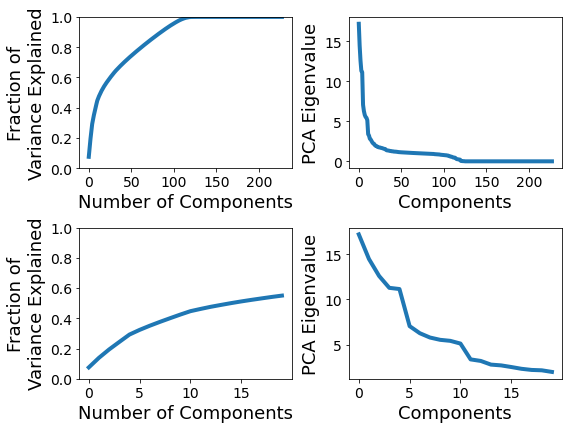

In [33]:
df_pca_scaled = StandardScaler().fit_transform(df_pca)

# Conducting PCA 
pca = PCA().fit(df_pca_scaled) 
explained_variance = np.copy(pca.explained_variance_ratio_)
explained_variance_sum = explained_variance

# Variance explained
for i in range(1, len(explained_variance_sum)) :
    explained_variance_sum[i] += explained_variance_sum[i-1] 

# Scree Plot
plt.figure(figsize=(8, 6))

plt.subplot(2, 2, 1)
plt.plot(explained_variance_sum)
plt.xlabel("Number of Components")
plt.ylabel("Fraction of\nVariance Explained")
plt.ylim(0, 1)

plt.subplot(2, 2, 2)
plt.plot(pca.explained_variance_)
plt.xlabel("Components")
plt.ylabel("PCA Eigenvalue")

idx_max = 20
plt.subplot(2, 2, 3)
plt.plot(explained_variance_sum[:idx_max])
plt.xlabel("Number of Components")
plt.ylabel("Fraction of\nVariance Explained")
plt.ylim(0, 1)

plt.subplot(2, 2, 4)
plt.plot(pca.explained_variance_[:idx_max])
plt.xlabel("Components")
plt.ylabel("PCA Eigenvalue")

plt.tight_layout()
plt.savefig("./figs/pca_cum_var.png", bbox_inches="tight")

# PC Scores
pc_score = pca.transform(df_pca_scaled)

print(explained_variance_sum[:5])

In [34]:
print(df_pca.columns[np.argsort(np.abs(pca.components_[0, :]))][:20])
print(df_pca.columns[np.argsort(np.abs(pca.components_[1, :]))][:20])


Index(['HemaSize_Large', 'SeizLen_>15 min', 'VomitLast_1-4 hrs before ED',
       'SFxBas_Unknown', 'HemaLoc_Parietal/Temporal',
       'GCSMotor_Pain withdraws', 'SFxPalp_Unknown', 'Drugs_Unknown',
       'VomitStart_Before head injury', 'High_impact_InjSev_Moderate',
       'SFxPalpDepress_No', 'SFxPalpDepress_Yes',
       'VomitStart_>4 hrs after event', 'VomitLast_>4 hrs before ED',
       'HemaLoc_Unknown', 'HAStart_>4 hrs after event', 'Intubated_Unknown',
       'Sedated_Unknown', 'SeizOccur_Unknown', 'Paralyzed_Unknown'],
      dtype='object')
Index(['SFxPalpDepress_Yes', 'Intubated_Yes', 'Paralyzed_Yes', 'Hema_Unknown',
       'SFxPalpDepress_Unknown', 'GCSMotor_Pain withdraws', 'SFxPalp_No',
       'SFxBasRet_Yes', 'High_impact_InjSev_Moderate', 'AMS_Unknown',
       'SFxPalp_Yes', 'SFxPalpDepress_Not applicable', 'SFxBasRhi_Yes',
       'SFxPalp_Unclear', 'FontBulg_Yes', 'Sedated_Yes',
       'High_impact_InjSev_Unknown', 'SFxPalpDepress_No', 'Vomit_Unknown',
       'SeizLen

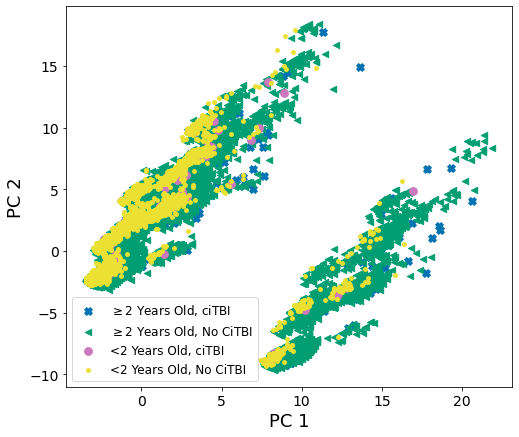

In [35]:
plt.figure(figsize=(8, 7))
color_idx = 0
marker_list = ["x", "<", "o", "."]
color_list_local = [color_list[0], color_list[2], color_list[4], color_list[8]]
for age_str, age_val in zip([r'$\geq$' +  '2 Years Old', '<2 Years Old'], [2, 1]):
    for outcome_str, outcome_val in zip(["ciTBI", "No CiTBI"], [1, 0]):
        sample_idx = (df_pca_key["AgeTwoPlus"] == age_val) & (df_pca_key["outcome"] == outcome_val)
        
        if 1 == age_val:
            sz = 60
        else:
            sz = 40
        plt.scatter(pc_score[sample_idx, 0], pc_score[sample_idx, 1], 
                    label=age_str + ", " + outcome_str,
                    s=sz, marker=marker_list[color_idx],
                    color=color_list_local[color_idx]
                   )
        color_idx += 1
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend()
plt.savefig("./figs/pca_age_outcome.png", bbox_inches="tight")

0.1007541833608296


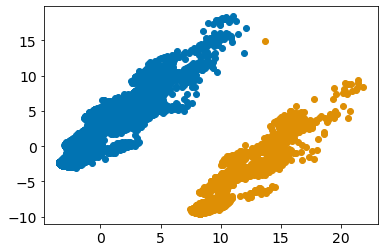

In [36]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=0).fit(pc_score[:, 0:2])
km_labels = kmeans.predict(pc_score[:, 0:2])

print(km_labels.mean())
plt.figure()
plt.scatter(pc_score[km_labels == 0, 0], pc_score[km_labels == 0, 1], color=color_list[0])
plt.scatter(pc_score[km_labels == 1, 0], pc_score[km_labels == 1, 1], color=color_list[1])



In [37]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
print((one_hot_df.loc[km_labels == 1].mean() - one_hot_df.loc[km_labels == 0].mean()).sort_values())
pd.set_option("display.max_rows", 20, "display.max_columns", 20)

OSIAbdomen_Not applicable                            -0.999766
OSIExtremity_Not applicable                          -0.999766
OSICspine_Not applicable                             -0.999766
OSIFlank_Not applicable                              -0.999766
OSIPelvis_Not applicable                             -0.999766
OSICut_Not applicable                                -0.999766
OSIOth_Not applicable                                -0.999766
OSI_No                                               -0.994996
Amnesia_verb_Pre/Non-verbal                          -0.235995
HA_verb_Pre/Non-verbal                               -0.229080
LOCSeparate_No                                       -0.215895
LocLen_Not applicable                                -0.167562
InjuryMech_Fall from an elevation                    -0.136930
High_impact_InjSev_Low                               -0.135308
ActNorm_Yes                                          -0.126383
ClavFace_No                                          -0

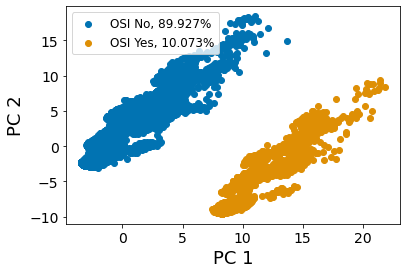

In [38]:
plt.figure()
plt.scatter(pc_score[one_hot_df["OSI_Yes"] == 0, 0], 
            pc_score[one_hot_df["OSI_Yes"] == 0, 1], 
            label="OSI No, " + str(np.round(100 * (one_hot_df["OSI_Yes"] == 0).mean(), decimals=3)) + "%",
            color=color_list[0])
plt.scatter(pc_score[one_hot_df["OSI_Yes"] == 1, 0], 
            pc_score[one_hot_df["OSI_Yes"] == 1, 1], 
            label="OSI Yes, " + str(np.round(100 * (one_hot_df["OSI_Yes"] == 1).mean(), decimals=3)) + "%",
            color=color_list[1])
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend()
plt.savefig("./figs/pca_osi.png", bbox_inches="tight")